In [171]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import sounddevice as sd
from scipy.io import wavfile
from scipy import signal

from torchvision.io import read_image
from torchvision.transforms import ToPILImage
import torch
import torch.nn.functional as F
from PIL import Image

In [172]:
M=5
P=2
Q=4
R=0

# 1. Vremenske transformacije
### a)

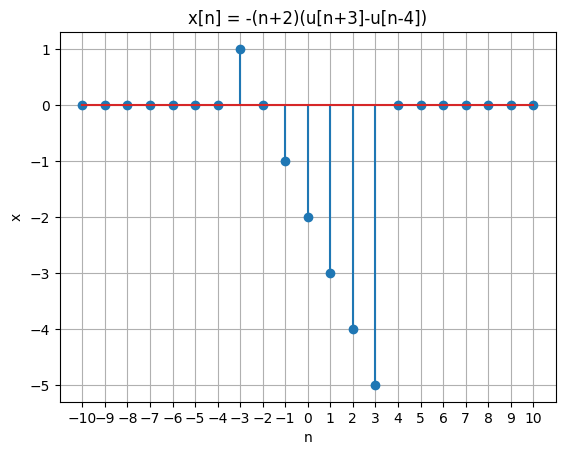

In [173]:
start_t = -10
end_t = 10
t = np.linspace(start_t, end_t, end_t-start_t+1)
x = -(t+2)*((t>=-3).astype(int) - (t>=4).astype(int))
plt.figure()
plt.stem(t,x)
plt.xlabel('n')
plt.ylabel('x')
plt.xticks(t)
plt.grid(True)
plt.title('x[n] = -(n+2)(u[n+3]-u[n-4])')

plt.show()

### b)

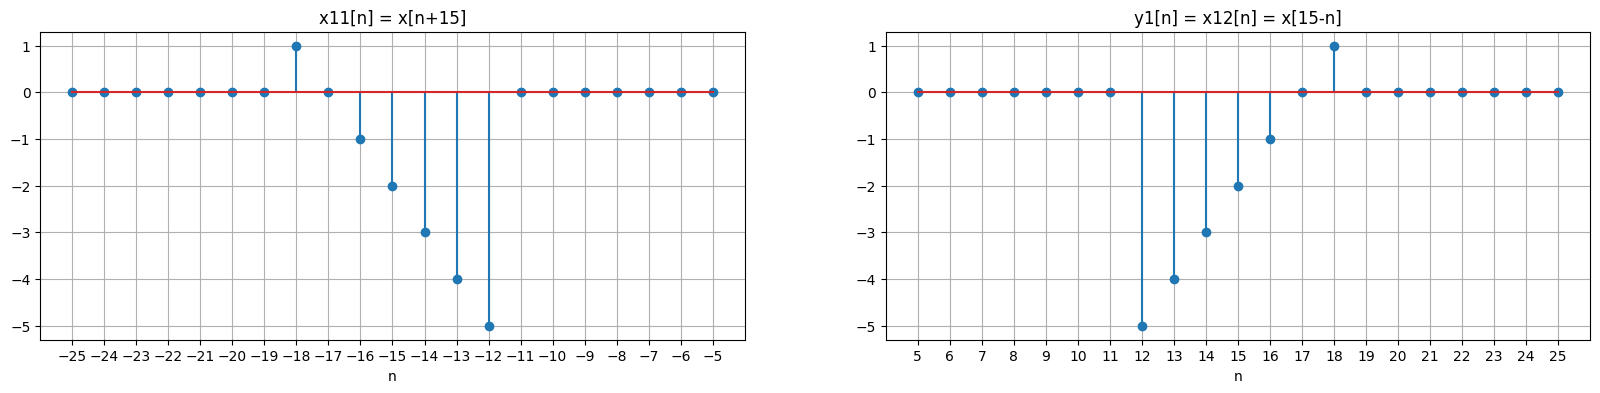

In [174]:

fig, ax = plt.subplots(1,2)
fig.set_size_inches((20,4))
for axi in ax:
    axi.set_xlabel('n')
    axi.grid(True)

t1 = t-3*(Q+1)

ax[0].stem(t1,x)
ax[0].set_title('x11[n] = x[n+15]')
ax[0].set_xticks(t1)
#plt.title('y[n] = x[15 + n]')

t2 = -t1[::-1]
x2 = x[::-1]

ax[1].stem(t2,x2)
ax[1].set_title('y1[n] = x12[n] = x[15-n]')
ax[1].set_xticks(t2)

#R+1 = 1 tako da nema skaliranja

plt.show()

Analiticki oblik:

$ y[n] = (n-17)*(u[n-12] - u[n-19]) $ 

<StemContainer object of 3 artists>

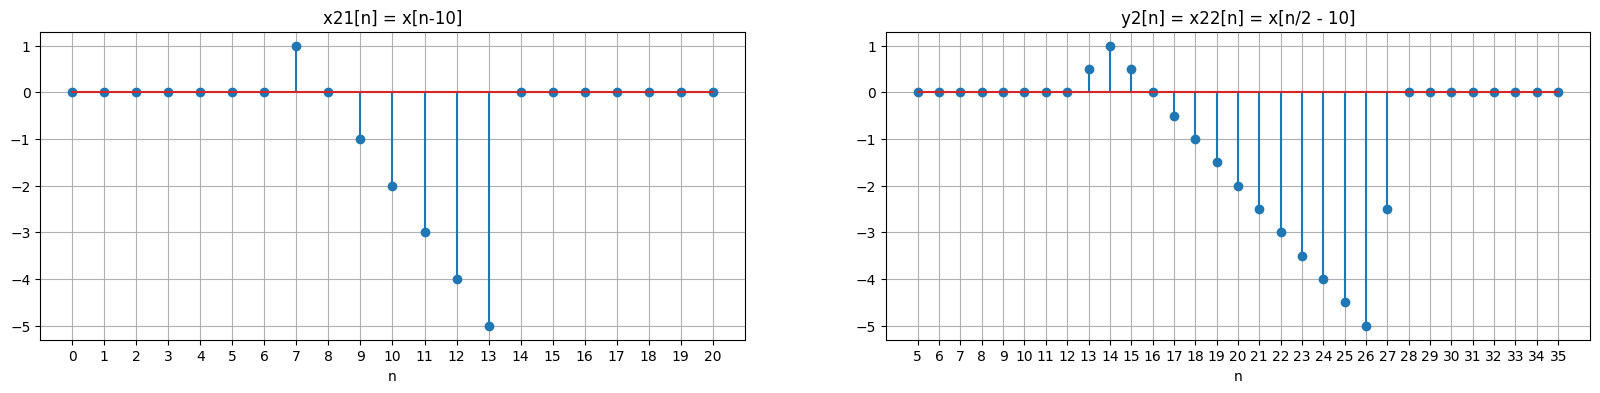

In [175]:
# t2 = (-2*(Q+1) + t/2)[::2];
# plt.figure()
# plt.stem(t2,x[::2])
# plt.xlabel('n')
# plt.ylabel('y')
# plt.xticks(t2)
# plt.grid(True)
# plt.title('y[n] = x[-10 + n/2]')

# plt.show()

fig, ax = plt.subplots(1,2)
fig.set_size_inches((20,4))
for axi in ax:
    axi.set_xlabel('n')
    axi.grid(True)

t1 = t + 2*(Q+1)
ax[0].set_title('x21[n] = x[n-10]')
ax[0].set_xticks(t1)
ax[0].stem(t1,x)

#nema inverzije

t2=np.linspace(2*t1[0], 2*t1[-1], 2*len(t1)-1)
x2 = np.zeros_like(t2)
x2[::2] = x
x2[1::2] = (x[:-1]+x[1:])/2

x2 = x2[5:-5] #skracivanje zbog preglednosti
t2 = t2[5:-5]

ax[1].set_title('y2[n] = x22[n] = x[n/2 - 10]')
ax[1].set_xticks(t2)
ax[1].stem(t2,x2)


Koriscena je linearna interpolacija. TODO

Analiticki oblik: TODO



# 2. Konvolucija
### a)

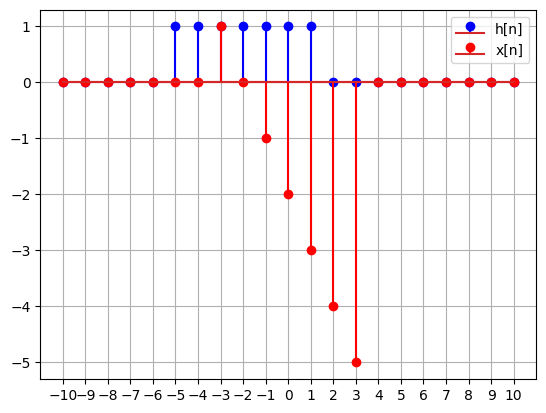

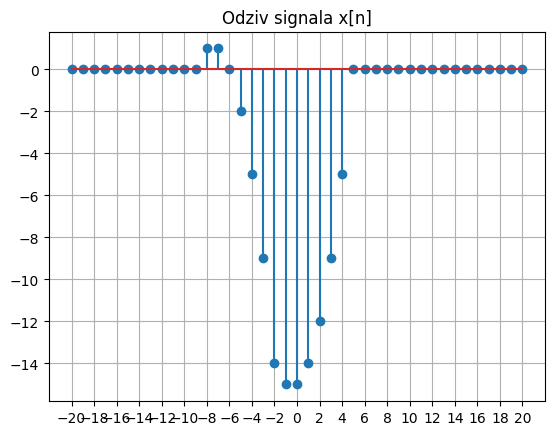

In [176]:
th=t #isto od -10 do 10
h = np.zeros_like(th)
h = (t>=-5) & (t<=1)
tc = np.linspace(t[0]+th[0], t[-1]+th[-1], len(th)+len(t)-1)
plt.stem(th,h, 'blue', label = 'h[n]')
plt.stem(t,x, 'red', label = 'x[n]')
plt.xticks(t if len(t)>len(th) else th)
plt.legend()
plt.grid(True)
plt.show()
ir = np.convolve(x, h)
plt.stem(tc, ir)
plt.xticks(tc[::2])
plt.title('Odziv signala x[n]')
plt.grid(True)
plt.show()

Radjeno je sa matricama $ M_0, M_1, M_2, M_6$.

TestSlika.png
Identical TestSlika.png
result_2d.max()=tensor(255.), result_2d.min()=tensor(5.3333)

Blurred TestSlika.png
result_2d.max()=tensor(246.), result_2d.min()=tensor(29.2593)

Sharpened TestSlika.png
result_2d.max()=tensor(678.3333), result_2d.min()=tensor(-229.)

DiagonalEdges TestSlika.png
result_2d.max()=tensor(650.3333), result_2d.min()=tensor(-747.6667)

mnist_2.png
Identical mnist_2.png
result_2d.max()=tensor(255.), result_2d.min()=tensor(0.)

Blurred mnist_2.png
result_2d.max()=tensor(252.6667), result_2d.min()=tensor(0.)

Sharpened mnist_2.png
result_2d.max()=tensor(810.), result_2d.min()=tensor(-593.)

DiagonalEdges mnist_2.png
result_2d.max()=tensor(986.), result_2d.min()=tensor(-976.)



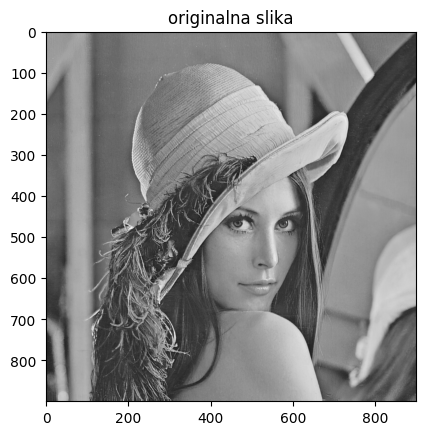

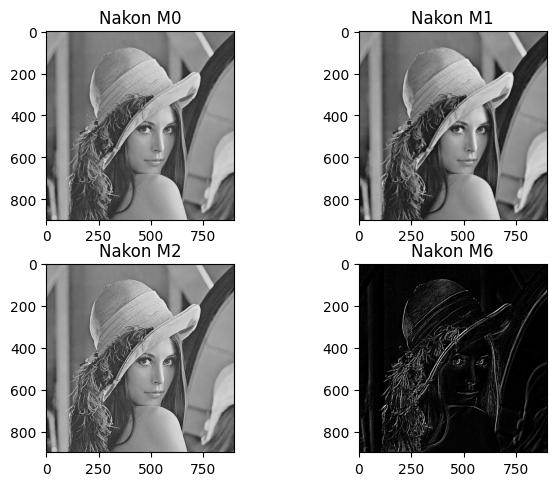

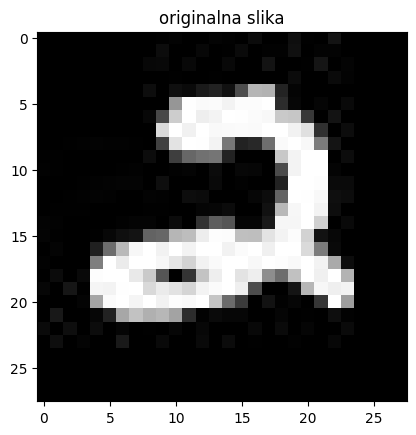

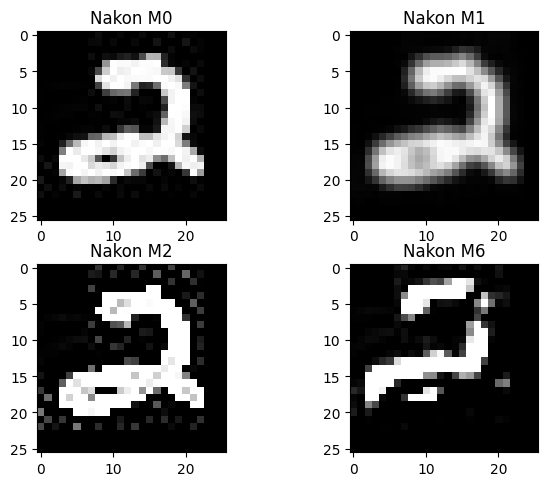

In [ ]:
M0 = torch.zeros((3,3))
M0[1,1] = 1
M1 = torch.full((3,3),1/9)
M2 = torch.tensor([[0,-1,0],[-1,5,-1],[0,-1,0]])
M6 = torch.arange(3) + torch.arange(3).unsqueeze(1).expand((3,3)) - 2

toPIL = ToPILImage(mode = 'L') #transformacija tenzora

def convolve(img, kernel, filename):
    batched_img = img.reshape((1,1,*img.shape))
    batched_kernel = kernel.float().reshape((1,1,3,3))
    result_4d = F.conv2d(batched_img, batched_kernel)
    result_3d = result_4d[0]
    result_2d = result_3d[0]
    print(filename)
    print(f'{result_2d.max()=}, {result_2d.min()=}')
    print()
    pil_friendly_result = result_3d.clip(0,255).byte()#.expand((3,*result_2d.shape))
    
    pil_image = toPIL(pil_friendly_result)
    # mkdir('../output')
    pil_image.save('../output/' + filename)

    return pil_friendly_result[0] #pogodno za plt.imshow


def process_image(img_path: str):
    img = read_image(img_path).float().mean(dim=0)
    fig, ax = plt.subplots(1,1)
    ax.imshow(img.numpy(), cmap='gray')
    ax.set_title('originalna slika')

    raw_name = img_path.split('/')[-1]
    name = raw_name.split('.')[0] + '.png'

    print(name)

    cropped_img = convolve(img, M0, 'Identical ' + name)
    blurred_img = convolve(img, M1, 'Blurred ' + name)
    sharpened_img = convolve(img, M2, 'Sharpened ' + name)
    diagonal_edges_img = convolve(img, M6, 'DiagonalEdges ' + name)

    fig, ax = plt.subplots(2,2)
    fig.tight_layout()

    ax[0][0].imshow(cropped_img, cmap = 'gray')
    ax[0][0].set_title('Nakon M0')

    ax[0][1].imshow(blurred_img, cmap = 'gray')
    ax[0][1].set_title('Nakon M1')

    ax[1][0].imshow(sharpened_img, cmap = 'gray')
    ax[1][0].set_title('Nakon M2')

    ax[1][1].imshow(diagonal_edges_img, cmap = 'gray')
    ax[1][1].set_title('Nakon M6')

process_image('../TestSlika.png')
process_image('../mnist_2.jpg')